# Exploratory Data Analysis: Who uses mobile payment?


## Summary of this notebook

### Overview

This analysis is the first part of the project to provide insights on **characteristics of mobile payment adopters** via exploratory data analysis. Mobile payment adopter is defined as using tap-and-pay at the point of sale in the last 12 months. 

- This question is of interest to merchants and especially small-scale businesses, who may consider whether to accept mobile payment in store. By comparing characteristics of target consumers and mobile payment adopters, businesses can evaluate the potential benefit and cost of accepting mobile payment.

- Mobile payment app developers may also be interested in knowing the characteristics of likely adopters for marketing purposes and room for potential expansion.

I use data from 2019 Survey of Consumer Payment Choice, a yearly survey conducted by the Federal Reserve Bank of Atlanla, for the project.

### High-level findings

By comparing how each *individual* feature is related to mobile payment adoption rate, I find that:

- In general, younger, wealthier, more educated, employed and single consumers are more likely to be adopters of mobile payment

- Mobile payment adoption rate is the highest in East South Central and Pacific census division.

However, it is important to keep in mind that features are correlated with each other. To determine the importance of each for prediction, I will train various machine learning models to investigate feature importance. This is done in the model training notebook.

### Methodology

- For each variable, I look at:
    - Distribution of the variable
    - The relationship between the features and mobile payment adoption
    - Survey weights are incorporated in the analysis

- Calculate correlation matrix for continuous variables

- At the end of this notebook, I carry out data cleaning steps to prepare data for model training. Steps include:

    - Handling missing data
    - Recoding values
    - Log transformation to handle skewed distribution


## References

- Federal Reserve Bank of Atlanta. (2020, May 19). 2019 SCPC Questionnaire. Retrieved September 26, 2021, from https://www.atlantafed.org/-/media/documents/banking/consumer-payments/survey-of-consumer-payment-choice/2019/2019_SCPC_Questionnaire.pdf. 

- Foster, K. (2020, April 10). Codebook and Data Guide to the 2019 Survey of Consumer Payment Choice. Retrieved September 26, 2021, from https://www.atlantafed.org/-/media/documents/banking/consumer-payments/survey-of-consumer-payment-choice/2019/scpc_2019_codebook.pdf. 

- Foster, K., Greene, C., &amp; Stavins, J. (2020, June 16). The 2019 Survey of Consumer Payment  Choice: Summary Results. Retrieved September 26, 2021, from https://doi.org/10.29338/rdr2020-03. 

#  Load packages and data

In [1]:
import pandas as pd
import matplotlib 
import numpy as np
from statsmodels.stats.weightstats import DescrStatsW
import statsmodels.api as sm
import statsmodels.formula.api as smf
from patsy import dmatrices
from sklearn.feature_extraction import DictVectorizer

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle # for matching colors
import seaborn as sns
import geopandas
from mpl_toolkits.axes_grid1 import make_axes_locatable

#statisc images of plot embedded in the notebook
%matplotlib inline 

# set plotting style used
plt.style.use('seaborn-whitegrid')

# Set the color paletter
sns.set_palette('Set2')

In [2]:
# Just for final uploaded version
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Display multiple output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [4]:
# Pandas display setting
# Adopted from https://songhuiming.github.io/pages/2017/04/02/jupyter-and-pandas-display/
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

## Load data

In [5]:
df_raw = pd.read_csv('../data/raw/scpc_2019_public_csv.csv')

In [6]:
df_raw.head()

,id,start_date,end_date,gender,dateofbirth_year,age,agerange,maritalstatus,livewithpartner,education,hisplatino,hisplatino_group,white,black,nativeamer,asian,pacific,race,working,sick_leave,unemp_layoff,unemp_look,retired,disabled,lf_other,laborstatus,employmenttype,workfullpart,hourswork,hhincome,cellphone,fr001_a,fr001_b,fr001_d,fr001_e,as003_a4,as003_b4,as003_h4,as003_c4,as003_d4,as003_e4,as003_f4,as003_g4,as003_g1,as003_h1,as003_a1,as003_b1,as003_c1,as003_d1,as003_e1,as003_f1,as003_h2,as003_g2,as003_f2,as003_e2,as003_d2,as003_c2,as003_b2,as003_a2,as003_a3,as003_b3,as003_c3,as003_d3,as003_e3,as003_f3,as003_g3,as003_h3,as003_h5,as003_a5,as003_b5,as003_c5,as003_d5,as003_e5,as003_f5,as003_g5,as003_h6,as003_a6,as003_b6,as003_c6,as003_d6,as003_e6,as003_f6,as003_g6,pa001_a,pa001_b,pa002_other,pa007_a,pa004_a,pa031,pa035,pa008_b1,pa008_a1,pa011_a,pa012,pa013,pa026_a,pa014,pa050,pa016_other,pa053,pa019_a,pa019_f,pa019_g,pa019_b,pa019_c,pa019_d,pa019_e,pa054_a1,pa054_a2,pa054_f1,pa054_f2,pa054_g1,pa054_g2,pa054_b1,pa054_b2,pa054_c1,pa054_c2,pa054_d1,pa054_d2,pa054_e1,pa054_e2,pa198_a,pa198_c,pa198_d,pa198_e,pa198_f,pa198_m,pa198_g,pa198_h,pa198_i,pa198_j,pa198_k,pa198_l,pa198_b,pa024,pa120_a,pa120_c_other,pa121_a,pa121_b,pa123_a_number,pa123_a_us,pa123_b_number,pa123_b_us,pa040_a,pa040_b,pa040_c,pa040_d,pa075_a,pa075_b,pa079_a,pa079_b,pa076_a,pa076_b,pa004_b,pa008_a2,pa008_a3,pa008_b2,pa008_b3,pa108_a,pa108_a_other,pa108_b,pa108_b_other,pa011_b,pa011_c,pa131a1,pa121_c,pa121_g,pa121_h,pa121_i,pa121_j,pa126_a_other,pa123_c_number,pa123_g_number,pa123_h_number,pa123_i_number,pa123_j_number,pa123_c_us,pa123_g_us,pa123_h_us,pa123_i_us,pa123_j_us,pa123_other,pa139,pa128_a,pa128_b,pa128_c,pa128_g,pa128_h,pa128_i,pa128_j,pa140_a,pa140_b,pa140_c,pa140_g,pa140_h,pa140_i,pa140_j,pa054_z,pa054_cards,pa045,pa202_a,pa202_c,pa202_d,pa202_e,pa202_f,pa202_m,pa202_g,pa202_h,pa202_i,pa202_j,pa202_k,pa202_l,pa203_a,pa203_c,pa203_d,pa203_e,pa203_f,pa203_m,pa203_g,pa203_h,pa203_i,pa203_j,pa203_k,pa203_l,pa194,pa193,pa193_other,pa188,pa188_other,pa044_a,pa189_a,pa189_b,pa189_c,pa045_a,pa045_b,pa054_a,pa054_b,pa054_c,pa054_d,pa054_e,pa054_f,pa054_g,pa120_b1,pa120_b2,pa120_c,pa051_a,pa051_b,pa051_c,pa051_d,pa051_e,...,pu002_c,pu002_d,pu002_e,pu002_f,pu003_a,pu003_b,pu003_c,pu003_d,pu003_e,pu004_a,pu004_b,pu004_bmo,pu004_c,pu004_d,pu004_e,pu004_f,pu005_a,pu005_amo,pu005_b,pu005_c,pu005_d,pu005_e,pu006a_a,pu006a_b,pu006a_bmo,pu006a_c,pu006a_d,pu006a_e,pu006c_a,pu006c_b,pu006c_bmo,pu006c_c,pu006c_d,pu006c_e,pu021_a,pu021_b,pu021_bmo,pu021_c,pu021_d,pu021_e,pu021_f,pu021_g,pa002,pa016,pa126_a,ph009_a,ph009_b,ph009_c,ph009_d,surveyyear,hold_cash,paid_cash,pa008_b,pa008_a,csh_adopt,chk_acnt_adopt,sav_acnt_adopt,bnk_acnt_adopt,chk_adopt,mon_adopt,dc_adopt,cc_adopt,svc_adopt,obbp_adopt,banp_adopt,income_adopt,abp_adopt,f_pu004_a,f_pu006a_a,f_pu006c_a,f_pu021_a,f_pu004_bmo,f_pu005_amo,f_pu006a_bmo,f_pu006c_bmo,f_pu021_bmo,f_pu004_b,f_pu005_a,f_pu006a_b,f_pu006c_b,f_pu021_b,f_pu002_a,f_pu003_a,f_pu004_c,f_pu005_b,f_pu006a_c,f_pu006c_c,f_pu021_c,f_pu002_b,f_pu003_b,f_pu004_d,f_pu005_d,f_pu006a_d,f_pu006c_d,f_pu021_d,f_pu004_e,f_pu005_e,f_pu006a_e,f_pu006c_e,f_pu002_e,f_pu003_d,f_pu021_f,f_pu002_c,f_pu003_c,f_pu005_c,f_pu021_e,f_pu002_d,f_pu002_f,f_pu003_e,f_pu004_f,f_pu021_g,pu004_a_unedited,pu006a_a_unedited,pu006c_a_unedited,pu021_a_unedited,pu004_bmo_unedited,pu005_amo_unedited,pu006a_bmo_unedited,pu006c_bmo_unedited,pu021_bmo_unedited,pu004_b_unedited,pu005_a_unedited,pu006a_b_unedited,pu006c_b_unedited,pu021_b_unedited,pu002_a_unedited,pu003_a_unedited,pu004_c_unedited,pu005_b_unedited,pu006a_c_unedited,pu006c_c_unedited,pu021_c_unedited,pu002_b_unedited,pu003_b_unedited,pu004_d_unedited,pu005_d_unedited,pu006a_d_unedited,pu006c_d_unedited,pu021_d_unedited,pu004_e_unedited,pu005_e_unedited,pu006a_e_unedited,pu006c_e_unedited,pu002_f_unedited,pu003_e_unedited,pu002_e_unedited,pu003_d_unedited,pu021_f_unedited,pu002_c_unedited,pu003_c_unedited,pu005_c_unedited,pu02

In [7]:
df_raw.info(verbose = True, show_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3372 entries, 0 to 3371
Data columns (total 591 columns):
 #    Column                  Non-Null Count  Dtype  
---   ------                  --------------  -----  
 0    id                      3372 non-null   int64  
 1    start_date              3372 non-null   int64  
 2    end_date                3349 non-null   float64
 3    gender                  3372 non-null   int64  
 4    dateofbirth_year        3372 non-null   int64  
 5    age                     3372 non-null   int64  
 6    agerange                5 non-null      float64
 7    maritalstatus           3371 non-null   float64
 8    livewithpartner         1338 non-null   float64
 9    education               3372 non-null   int64  
 10   hisplatino              3372 non-null   int64  
 11   hisplatino_group        268 non-null    float64
 12   white                   3364 non-null   float64
 13   black                   3364 non-null   float64
 14   nativeamer            

## Self-defined functions

In [8]:
# Show fraction
# Check missing values & coresponding percentage
def show_percent_missing(df):

    dtmp = df.isnull().sum().sort_values(ascending = False)\
        .pipe(pd.DataFrame, columns = ['missing'])\
        .assign(total = df.shape[0],
               percent = lambda x: round(x.missing / x.total * 100, 2))\
        .drop('total', axis = 1)
    
    return dtmp

# Preliminary data cleaning

**Goals**:

- Extract a subset of variables of interest and rename them

- Filling in *systematic missing values* due to the survey structure

- Remove observations with zero weights


In [9]:
# First, select a subset of variables of interest
# First, extract variables that I need before generating any report
vars_subset = ['age', 'cellphone', 'census_division', 'currentlivingsituation', 
           'de013', 'de014', 'de016',
            'education', 'employmenttype', 'gender', 'hhincome',
            'hourswork', 'laborstatus', 
            'race', 
            'id', 'ph006', 
               'r_weight', 'cc_adopt', 'cc_typ', 'dc_adopt', 'dc_typ',
               'pa189_a']
# list_names_assess = ['as003_'+ a + str(b) for a in ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h'] for b in range(1, 7)]

df_raw_subset = df_raw.loc[:,vars_subset].copy()

In [10]:
df_raw_subset.shape

(3372, 22)

## Rename variables
Rename the variable names so they are more informative

In [11]:
dict_col_rename = {
    'gender':'male',
    'de013':'own_prim_home',
    'de014':'prim_home_mkt_value',
    'de016':'assets_non_home_mkt_value',
    'pa189_a':'mpay_tap_and_pay_1year',
    'ph006': 'fico_score'
}

df_raw_subset = df_raw_subset.rename(columns = dict_col_rename)

## Clean values/ recode values

Some binary variables take valuse 1/2 instead of (0/1), so I am recode them in this section. 

In [12]:
# Clean binary variable with values 1/2 to 0/1, keeping NA values intact
vars_clean_values = [
    'cellphone', 'mpay_tap_and_pay_1year', 'own_prim_home'
]

df_raw_subset[vars_clean_values] = df_raw_subset[
    vars_clean_values].apply(lambda x: x.apply(lambda y: 0
                                                    if y == 2 else y))

## Fillilng in systematic missing values

- I filter out observations without cellphone or with the outcome variable (mapy_tap_and_pay_1year) missing

- Here, I will fill in systematic missing values due to the survey strcuture. For example, if a person does not have a credit card, then he/she won't be shown any credit card related questions, and all those variables will become NA. This is different from different in nature than when a respondant intentionally leave an answer blank.

- The systematic missing values are backed out by looking at the questionnaire structure and references. This does not include missing survey answer, e.g., missing household income, missing race, etc.

In [13]:
df = df_raw_subset.copy()

In [14]:
# Drop variables with cellphone = 0, since I care about mobile payment
df = df.loc[(df_raw_subset.cellphone == 1) & (df_raw_subset.mpay_tap_and_pay_1year.notnull()),] .copy()

In [15]:
# First check what variables have lots of missing values
df.isnull().sum().sort_values(ascending = False)

hourswork                    1302
employmenttype               1302
dc_typ                       1088
cc_typ                       1088
prim_home_mkt_value           951
assets_non_home_mkt_value      77
dc_adopt                       54
own_prim_home                  15
fico_score                     14
race                            7
cc_adopt                        4
hhincome                        3
laborstatus                     3
census_division                 2
currentlivingsituation          1
r_weight                        0
age                             0
id                              0
cellphone                       0
male                            0
education                       0
mpay_tap_and_pay_1year          0
dtype: int64

### Actual filling in missing values

- If a person does not have to answer a question (e.g., because the person does not have credit card, then the person won't be asked the number of transactions, frauds assocaiated with credit cards. Then those values should just be zero).

In [16]:
vars_own_home_fillzero = ['prim_home_mkt_value']
df.loc[df.own_prim_home == 0, vars_own_home_fillzero] = 0

In [17]:
df[vars_own_home_fillzero].isnull().sum()

prim_home_mkt_value    33
dtype: int64

In [18]:
# For employment type, since it's categorical variable, I cannot fill it in
# Original: ['hourswork', 'workfullpart', 'employmenttype']
vars_labor_fillzero = ['hourswork']
df.loc[~df.laborstatus.isin([1,2]), vars_labor_fillzero] = 0

In [19]:
df[vars_labor_fillzero].isnull().sum()

hourswork    0
dtype: int64

In [20]:
# Check missing values & coresponding percentage
# While the above procedure cleans up *systematic* missing values, there can be other reasons for missings values
df.isnull().sum().sort_values(ascending = False)\
    .pipe(pd.DataFrame, columns = ['missing'])\
    .assign(total = df.shape[0],
           percent = lambda x: round(x.missing / x.total * 100, 2))\
    .drop('total', axis = 1)

,missing,percent
employmenttype,1302,40.14
dc_typ,1088,33.54
cc_typ,1088,33.54
assets_non_home_mkt_value,77,2.37
dc_adopt,54,1.66
prim_home_mkt_value,33,1.02
own_prim_home,15,0.46
fico_score,14,0.43
race,7,0.22
cc_adopt,4,0.12


## Removing observations with weight = 0

Since outcomes will be weighed by r_weight, any observation with r_weight = 0 will not be counted. To avoid division by 0 error later on, I will remove them here first

In [21]:
df = df.loc[df.r_weight > 0]

# Univariate data exploration
In this section, I look at how mobile payment adoption rate differs for respondants with different characteristics. 

Note: I do not include observations with missing values when doing the analysis (e.g., when I look at how adoption rate differs by census division, I do not use observations with missing census division.)

## Useful functions for visualization

I write these self-defined functions, since I would like to present *weighted* results and figures.

### General

In [22]:
# Calculate the percentage given a number
### Inputs
# x: a series of floats
# num_sig: number of significant figures (default = 3)
### Output:
# a series (same length as x) containing the rounded values of x (up to num_digits)
def get_percent(x, num_sig=3):

    return signif(x * 100, num_sig)

In [23]:
# A function to calculate significant figures
# Credits: https://stackoverflow.com/questions/18915378/rounding-to-significant-figures-in-numpy
### Inputs
# x = array
# p = number of significant figures
def signif(x, p):
    x = np.asarray(x)
    x_positive = np.where(np.isfinite(x) & (x != 0), np.abs(x), 10**(p - 1))
    mags = 10**(p - 1 - np.floor(np.log10(x_positive)))
    return np.round(x * mags) / mags

### Calculating weighted statistics

In [24]:
# For calculating sum and fraction of weights for a particular variable
### Inputs
# df: data frame
# x: name of outcome to be grouped by
# w: name of the weights columns
### Output:
# a pd.DataFrame containing the sum of weights and percent of weights, each row is a group
def find_weighted_mean_by_gp(df, x, w):

    df_gp = df.groupby(x)\
        .agg({w: 'sum'})\
        .assign(percent = lambda x: get_percent(x[w] / x[w].sum(), 2))

    return df_gp

In [25]:
# Function to give weighted summary statistics (similar ones to using .describe())
### Inputs
# x: series containing the values to describe
# w: same length as x, containing the weights
# name of the object to be called
### Output:
# a pd.Series containing various weighted summary statistics (mean, sd, min, max, quartiles)
def weighted_describe(x, w, name=''):

    if name:
        print('Weighted summary statistics for ' + name)

    # First initialize the DescrStatsW object (useful for calculating weighted quantiles)
    tmp_x = DescrStatsW(x, weights=w)
    summ_stat = pd.Series({
        'sum_w': w.sum(),
        'mean': tmp_x.mean,
        'std': np.sqrt(np.cov(x, aweights=w)),
        'min': np.min(x),
        '25%': tmp_x.quantile(0.25, return_pandas=False)[0],
        'median': tmp_x.quantile(0.5, return_pandas=False)[0],
        '75%': tmp_x.quantile(0.75, return_pandas=False)[0],
        'max': np.max(x),
    })

    return summ_stat

In [26]:
# Function to calculate standard error for a predicted value (se for the betaX not prediction error)
# formula: X * cov * X'
### Inputs
# X: an np array containing the regressors
# cov: covaraince matrix of the regression coefficients
def calculate_yhat_se(X, cov):
    return np.sqrt(np.diag(np.dot(X, cov).dot(X.T)))

### WLS and plots

In [27]:
# Function to plot variables with weighted least squares (y ~ x with weights)
### Inputs
# df: data df
# y: name of the outcome variable
# x: name of the regressor
# w: name of the weights
# cov_type: type of robust standard error to use
# thres: threshold for plotting ci
# print_WLS: whether to print the WLS results
### Ouputs
# res: WLS model fit
# fig: fig object
# ax: ax object
def plot_WLS(df, y, x, w, cov_type='HC1', thres=1.96, print_WLS=True):

    # Run weighted least squares
    formula = y + ' ~ ' + x
    mod = smf.wls(formula=formula, data=df, weights=df[w])
    res = mod.fit(cov_type=cov_type)

    if print_WLS:
        print(res.summary())

    # Calculated the following quantities for plotting;
    # 1. fitted values for a grid of values of age
    # 2. Standard error for the fitted values
    # 3. CI (95% two sided)
    cov_beta = res.cov_HC1
    x_upperbd = int(max(df[x]))
    x_lowerbd = int(min(df[x]))
    grid_X = np.column_stack((np.ones(x_upperbd - x_lowerbd + 1),
                              np.arange(x_lowerbd,
                                        x_upperbd + 1)))
    pred = res.predict(pd.DataFrame(grid_X[:, 1:], columns=[x]))
    pred_se = calculate_yhat_se(grid_X, cov_beta)
    ci_l = pred - thres * pred_se
    ci_u = pred + thres * pred_se

    # plot data and line
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(grid_X[:, 1], pred)
    ax.fill_between(grid_X[:, 1], ci_l, ci_u, alpha=0.2, color='C0')
    ax.set(xlabel=x, ylabel='fitted values: ' + y)
    ax.text(0.95,
            0.95,
            'Slope coefficient = ' + str(round(res.params[1], 3)),
            ha='right',
            transform=ax.transAxes)

    return res, fig, ax

### Histogram of weights

In [28]:
# Function for generating labels with default color scheme
# Adopted from https://stackoverflow.com/questions/57340415/matplotlib-bar-plot-add-legend-from-categories-dataframe-column
# and https://stackoverflow.com/questions/51468670/how-to-get-the-color-of-a-seaborn-matplotlib-bar-graph
# Add legend for the different values of labor status
# Note that this should be checked if the dict_labels aren't sorted when I insert values
# Also this only works for barplot because of the way it checks color
def generate_legend_labels(ax, dict_labels):

    i = 0
    bars = [r for r in ax.get_children() if type(r)==Rectangle]
    colors = [c.get_facecolor() for c in bars[:-1]]
    
    for key, val in dict_labels.items():  # Loop over color dictionary
        ax.bar(0, 0, width=0, color=colors[i], label=str(key) + ': ' +
               val)  #Plot invisible bar graph but have the legends specified
        i += 1


In [29]:
### Inputs
# df: data df
# var: the name of categorical variable to plot
# w: name of wieghts
# Labels: dict for the legend (key = unmerical value, value = label)
def plot_hist_wts_cat_var(df, var, w, dict_labels={}):

    # Fraction of weights by labor status
    fig, ax = plt.subplots(figsize=(8, 6))

    # Calculate the percent of total weights for each level of the categorical variable
    find_weighted_mean_by_gp(df, var, w)\
        .reset_index()\
        .pipe((sns.barplot, 'data'),
              x = var, y ='percent',
              ax = ax, ci = None)

    if dict_labels:
        generate_legend_labels(ax, dict_labels)
        ax.legend()

    ax.set(ylabel='Fraction of weights (%)',
           title='Distribution of weights by ' + var)

    return fig, ax

### Plotting weighted ourcome by group

In [30]:
### Inputs
# df: data df
# var_y: the name of outcome variable
# var_cat: the name of categorical variable
# var_w: name of wieghts
# dict_labels: dict for the legend (key = unmerical value, value = label)

def plot_weighted_outcome_by_group(df, var_y, var_cat, var_w, dict_labels):

    df_temp = df.assign(gp_weight = lambda x: x.groupby(var_cat)[var_w].transform('sum'))\
        .assign(val = lambda x: x[var_y] * x[var_w] / x.gp_weight)\
        .groupby(var_cat) \
        ['val'].sum()\
        .reset_index()\
        .assign(cat = lambda x: x[var_cat].apply(lambda y: str(y)))
                
    n_cat = df_temp.shape[0]
    if n_cat < 8:
        mycolor = sns.color_palette('Set2')[:n_cat]
    elif n_cat == 8:
        mycolor = sns.color_palette('Set2')
    else:
        mycolor = sns.color_palette('husl', n_cat)

    fig, ax = plt.subplots()
    
    ax.bar(x=df_temp['cat'],
          height=df_temp['val'],
          color=mycolor)
    
    if dict_labels:
        generate_legend_labels(ax, dict_labels)
        ax.legend()

    return fig, ax

### For plotting (continuous variables)

In [31]:
# x is more an order variable (finite number of values)
# Plot the weighed outcome by x
def plot_scatter_outcome_by_gp(df, outcome, gp):

    # Look at how y varies with x
    fig, ax = plt.subplots(figsize=(8, 6))

    # First, calculate the weighted outcome by gp, and calculate the sum of weights in each age group
    df_tmp = df.groupby(gp).apply(lambda x: pd.Series({
        **{y: np.average(x[y], weights = x.r_weight) for y in outcome},
        'w':x.r_weight.sum()
    })).reset_index()

    # Plot the weighted outcome by age group, size of the dot is proportional to the weights in te class
    for y in outcome:
        ax.scatter(df_tmp[gp],
                   df_tmp[y],
                   label=y,
                   s=2 * df_tmp.w,
                   alpha=0.5)
        
    ax.legend()
    
    return fig, ax

##  Look at the dependent variables

- Understand what fraction in the entire data uses

About 14% of all respondents uses tap-and-pay at the points of sale. This shows that the classes are not very balanced. When I train a classification model, I need to be careful about classes imbalances.

In [32]:
find_weighted_mean_by_gp(df, 'mpay_tap_and_pay_1year', 'r_weight')

,r_weight,percent
mpay_tap_and_pay_1year,,
0.0,2723.371506,86.0
1.0,457.610601,14.0


### Age

The mean/ median age is 47 and the 1st quartile is 33 after weighting

- Groups over 80 do not use mobile payment at all (except for a1/2 outlier groups)

- Even among the group who's most likely to use mobile payment, adoption rate of mobile tap-and-pay payment is 60-70% 

- Age seems to be negatively related to both variables (from the slope coefficients)

    - But there seems to be a bit of quadratic relationship -- for people close to 20, the adoption rate first increaes then decreases.
    
- There seems to be some outliers with either very yound (20) or very old age (over 80) with very high adoption rate.

<AxesSubplot:xlabel='age', ylabel='Density'>

[Text(0, 0.5, 'Density of weights'),
 Text(0.5, 1.0, 'Weighted distribution of age')]

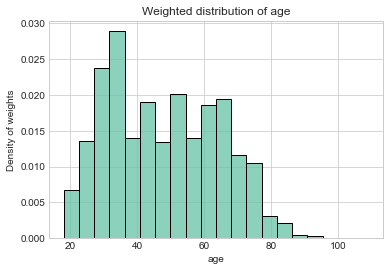

In [33]:
# Age
fig, ax = plt.subplots()
sns.histplot(x='age',
             ax=ax,
             weights='r_weight',
             data=df[df.age.notnull()],
             kde=False,
             bins=20,
             stat='density')
ax.set(ylabel='Density of weights',
      title = 'Weighted distribution of age')

In [34]:
# Calculate quantiles, mean and median
weighted_describe(x=df.age[df.age.notnull()], w=df.r_weight[df.age.notnull()], name='df.age')

Weighted summary statistics for df.age


sum_w     3180.982106
mean        47.823263
std         16.544160
min         18.000000
25%         33.000000
median      47.000000
75%         61.000000
max        109.000000
dtype: float64

                              WLS Regression Results                              
Dep. Variable:     mpay_tap_and_pay_1year   R-squared:                       0.031
Model:                                WLS   Adj. R-squared:                  0.031
Method:                     Least Squares   F-statistic:                     44.85
Date:                    Sun, 26 Sep 2021   Prob (F-statistic):           2.51e-11
Time:                            23:54:48   Log-Likelihood:                -1771.9
No. Observations:                    3192   AIC:                             3548.
Df Residuals:                        3190   BIC:                             3560.
Df Model:                               1                                         
Covariance Type:                      HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   

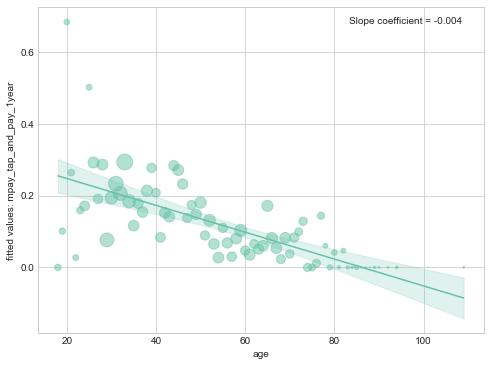

In [35]:
df_tmp = df[df.age.notnull()]\
    .groupby('age')\
    .apply(lambda x: pd.Series({
        'mpay_tap_and_pay_1year':np.average(x.mpay_tap_and_pay_1year,
                                            weights=x.r_weight),
        'w':x.r_weight.sum()
})).reset_index()
_, fig, ax = plot_WLS(df[df.age.notnull()], 'mpay_tap_and_pay_1year', 'age', 'r_weight')
ax.scatter(df_tmp.age, df_tmp.mpay_tap_and_pay_1year,
           label='mpay_tap_and_pay_1year', s=2 * df_tmp.w,
           alpha = 0.5)

###  Gender

There are more male than female in the data set

- Male has higher adoption rate for tap and pay

- Female population is slightly older (weighted median is 48 for women vs 45 for men)

- Fewer female are currently working


In [36]:
dict_labels_male = {
    0: 'female',
    1: 'male'
}

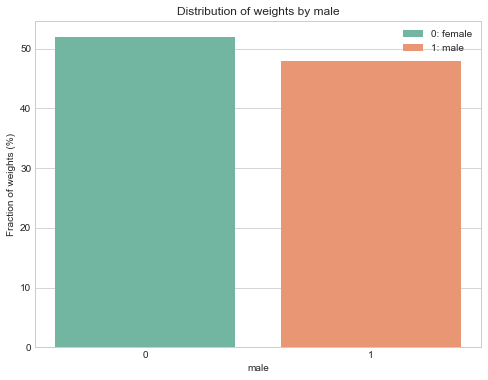

In [37]:
fig, ax = plot_hist_wts_cat_var(df[df.male.notnull()], 'male', 'r_weight', dict_labels_male)

[Text(0.5, 1.0, 'Adoption rate by gender'),
 Text(0, 0.5, 'average weighted adoption rate')]

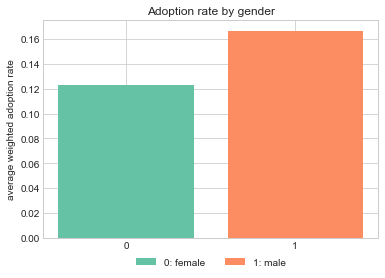

In [38]:
fig, ax = plot_weighted_outcome_by_group(df[df.male.notnull()],
                                         'mpay_tap_and_pay_1year',
                                         'male',
                                         'r_weight',
                                         dict_labels_male)
ax.set(title='Adoption rate by gender',
      ylabel='average weighted adoption rate')

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2)

<AxesSubplot:xlabel='age', ylabel='Count'>

[Text(0, 0.5, 'Sum of weights')]

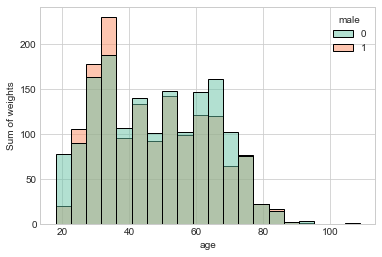

In [39]:
# Do we get similar gender ratio across all age groups
fig, ax = plt.subplots()
sns.histplot(x='age', ax=ax,
             hue='male', weights='r_weight',
             data=df[df.male.notnull()], kde=False,
             bins=20)
ax.set(ylabel='Sum of weights')

In [40]:
# Checking the distribution of age within gender
df[df.male.notnull()].groupby('male').apply(lambda x: weighted_describe(x.age, x.r_weight))

,sum_w,mean,std,min,25%,median,75%,max
male,,,,,,,,
0,1653.962758,48.311915,16.835066,18.0,33.0,48.0,63.0,109.0
1,1527.019349,47.293989,16.217890,18.0,33.0,45.0,60.0,101.0


<AxesSubplot:xlabel='laborstatus', ylabel='frac'>

[Text(0, 0.5, 'Fraction of weights (%)')]

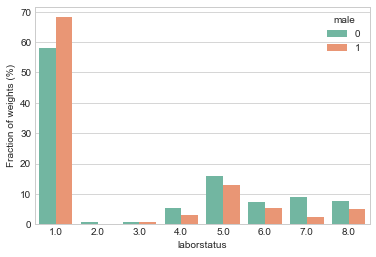

In [41]:
# Labor status by gender
# First sum up weights for each gender-labor status bin, then normalize by the total weights of each gender
# Show fraction of weights (within each gender) in each labor status
fig, ax = plt.subplots()
df.groupby(['male', 'laborstatus']).r_weight.sum()\
    .reset_index()\
    .assign(sum_weights = df.groupby('male').r_weight.transform('sum'),
           frac = lambda x: get_percent(x.r_weight / x.sum_weights))\
    .pipe((sns.barplot, 'data'), x = 'laborstatus', y = 'frac', hue = 'male', ci = None, ax = ax)

ax.set(ylabel = 'Fraction of weights (%)')

### Labor status

Most people are either working retired.

- note that there are people who choose several options (laborstatus = 8) so I need to be careful, e.g., create dummies instead or just be careful about interpretation). Also what does other mean?

- The group who's employed has the highest rate of adoption

- Retired group has lower adoption rate (but this is as expected because retired group is older on average probably


In [42]:
list_labels_laborstatus = ['Currently working', 'On sick or other leave',
                           'Unemployed - on layoff', 'Unemployed - looking',
                           'Retired', 'Disabled',
                           'Other', 'Selected some combination of above']

dict_labels_laborstatus = {
    1:'Currently working', 2:'On sick or other leave',
    3:'Unemployed - on layoff', 4:'Unemployed - looking',
    5:'Retired', 6:'Disabled',
    7:'Other', 8:'Selected some combination of above'
}

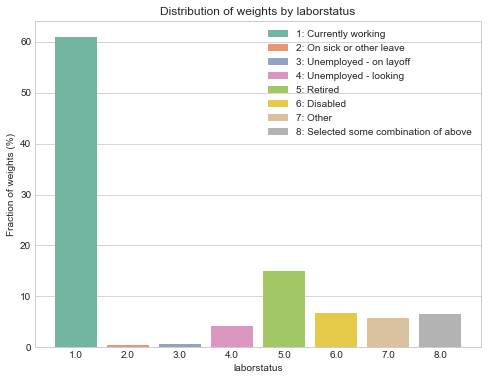

In [43]:
fig, ax = plot_hist_wts_cat_var(df[df.laborstatus.notnull()], 'laborstatus', 'r_weight', dict_labels_laborstatus)

[Text(0.5, 1.0, 'Adoption rate by labor status'),
 Text(0, 0.5, 'average weighted adoption rate')]

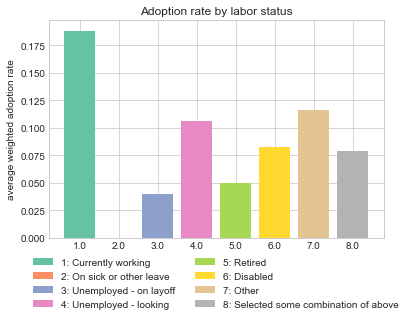

In [44]:
fig, ax = plot_weighted_outcome_by_group(df[df.laborstatus.notnull()], 'mpay_tap_and_pay_1year',
                                         'laborstatus', 'r_weight',
                                         dict_labels_laborstatus)
ax.set(title = 'Adoption rate by labor status',
      ylabel = 'average weighted adoption rate') 
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2)

#### Number of hours

Observations:

- Number of hours work is concentrated at 40 hours (intuitive)

- While on the figure there seems to be a slightly negative relationship between hours work and adoption rate, it is not statistically significant.

- Most employed respondants work in private sectors, and government employees have higher mobile payment adoption rate

<AxesSubplot:xlabel='hourswork', ylabel='Density'>

[Text(0.5, 1.0, 'Distribution of hourswork')]

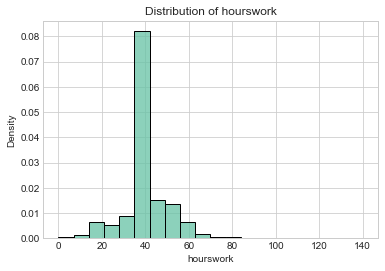

In [45]:
# Only look at people who are working/ on leave
fig, ax = plt.subplots()
sns.histplot(x = 'hourswork', data = df[(df.laborstatus.isin([1,2])) & (df.hourswork.notnull())],
             weights = 'r_weight', kde = False,
             bins = 20, stat = 'density')
ax.set(title='Distribution of hourswork')

[Text(0.5, 1.0, 'Average adoption rate by age'),
 Text(0.5, 0, 'Age'),
 Text(0, 0.5, 'Weighted adoption rate')]

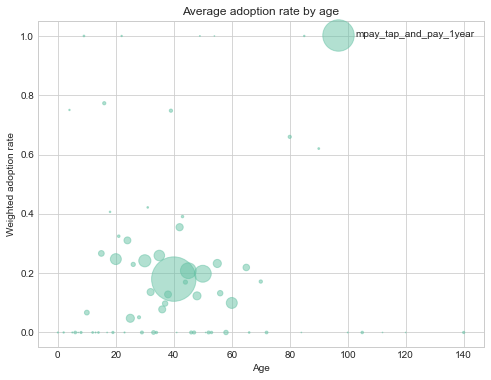

In [46]:
# Scatter plot - outcome by hourswork only for people who are working
fig, ax = plot_scatter_outcome_by_gp(df[(df.laborstatus.isin([1,2])) & (df.hourswork.notnull())], ['mpay_tap_and_pay_1year'], 'hourswork')
ax.set(title='Average adoption rate by age',
      xlabel='Age',
      ylabel='Weighted adoption rate')

                              WLS Regression Results                              
Dep. Variable:     mpay_tap_and_pay_1year   R-squared:                       0.001
Model:                                WLS   Adj. R-squared:                  0.000
Method:                     Least Squares   F-statistic:                    0.5130
Date:                    Sun, 26 Sep 2021   Prob (F-statistic):              0.474
Time:                            23:54:51   Log-Likelihood:                -1206.7
No. Observations:                    1773   AIC:                             2417.
Df Residuals:                        1771   BIC:                             2428.
Df Model:                               1                                         
Covariance Type:                      HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   

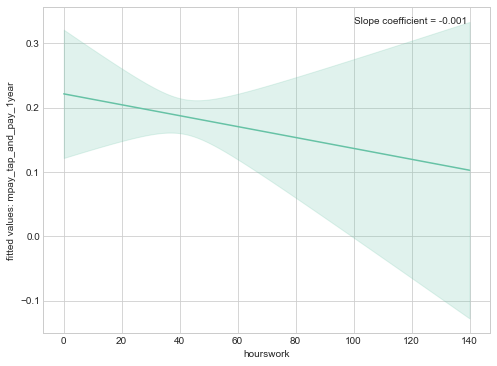

In [47]:
# WLS plot for people who are working
_, fig, ax = plot_WLS(df[df.laborstatus.isin([1,2])], 'mpay_tap_and_pay_1year', 'hourswork', 'r_weight')

#### Employment type

In [48]:
dict_labels_employmenttype = {
    1: 'Government',
    2: 'Private-for-profit company',
    3: 'Non-profit organization including tax exempt and charitable organizations',
    4: 'Self-employed'
    }

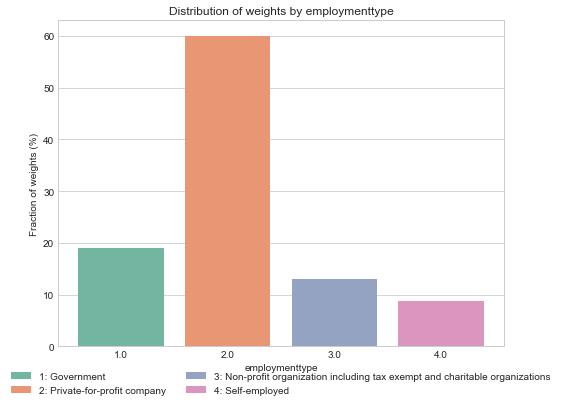

In [49]:
fig, ax = plot_hist_wts_cat_var(df[df.employmenttype.notnull()], 'employmenttype', 'r_weight', dict_labels_employmenttype)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2)

[Text(0.5, 1.0, 'Adoption rate by employment type'),
 Text(0, 0.5, 'average weighted adoption rate')]

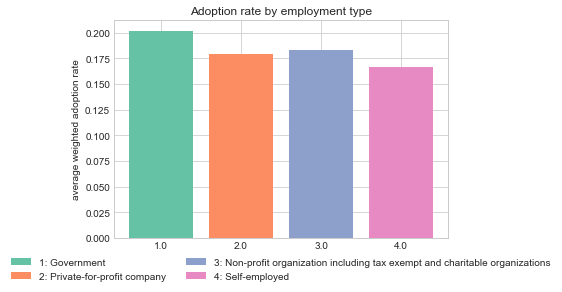

In [50]:
fig, ax = plot_weighted_outcome_by_group(df[df.employmenttype.notnull()], 'mpay_tap_and_pay_1year',
                                         'employmenttype', 'r_weight',
                                         dict_labels_employmenttype)
ax.set(title = 'Adoption rate by employment type',
      ylabel = 'average weighted adoption rate')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2)

### Race

- Most people identify themselves as white in the data

- Asian have high adoption rate, though it is important to remember that the fraction of weights is low for the group

In [51]:
list_xtick_labels_race = ['White', 'Black/African\nAmerican', 'American Indian/\nAlaska Native',
                         'Asian', 'Native Hawaiian/\nOther Pacific Islander', 'Combination\nof above']

dict_labels_race = {
    1:'White',
    2:'Black/ African American',
    3:'American Indian or Alaska Native',
    4:'Asian',
    5:'Native Hawaiian/ Other Pacific Islander',
    6:'Combination'
}

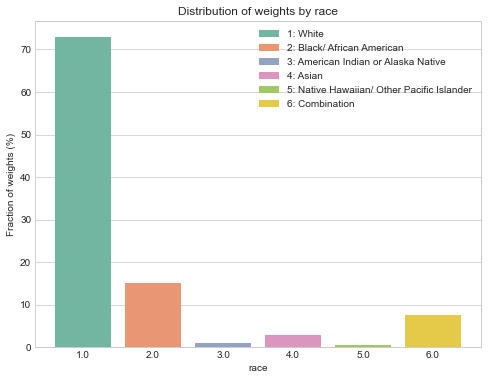

In [52]:
fig, ax = plot_hist_wts_cat_var(df[df.race.notnull()], 'race', 'r_weight', dict_labels_race)

[Text(0.5, 1.0, 'Adoption rate by race'),
 Text(0, 0.5, 'average weighted adoption rate')]

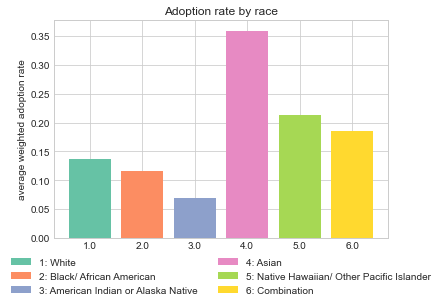

In [53]:
fig, ax = plot_weighted_outcome_by_group(df[df.race.notnull()], 'mpay_tap_and_pay_1year',
                                         'race', 'r_weight',
                                         dict_labels_race)
ax.set(title = 'Adoption rate by race',
      ylabel = 'average weighted adoption rate')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2)

### Region 

- The top 2 census divisions (in terms of fraction of weights) are East North Central and South Atlantic.

- Pacific and East South Central has higher adoption rate for tap and pay

In [54]:
dict_labels_region = {
    1:'New England',
    2:'Middle Atlantic',
    3:'East North Central',
    4:'West North Central',
    5:'South Atlantic',
    6:'East South Central',
    7: 'West South Central',
    8 :'Moutain',
    9: 'Pacific'
}

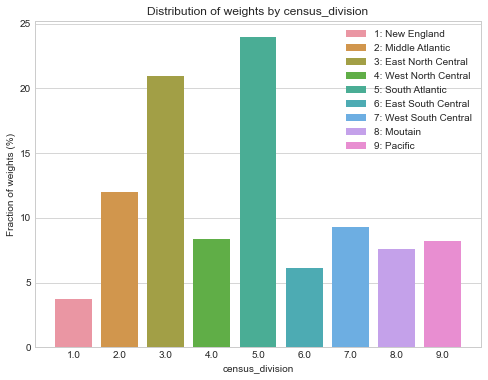

In [55]:
fig, ax = plot_hist_wts_cat_var(df[df.census_division.notnull()], 'census_division', 'r_weight', dict_labels_region)

[Text(0.5, 1.0, 'Adoption rate by census division'),
 Text(0, 0.5, 'average weighted adoption rate')]

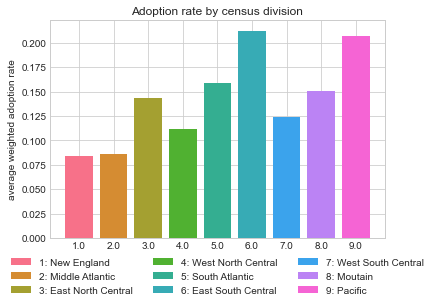

In [56]:
fig, ax = plot_weighted_outcome_by_group(df[df.census_division.notnull()], 'mpay_tap_and_pay_1year',
                                         'census_division', 'r_weight',
                                         dict_labels_region)
ax.set(title = 'Adoption rate by census division',
      ylabel = 'average weighted adoption rate')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=3)

In [57]:
# Plot adoption rate on map
states = geopandas.read_file('../data/map/cb_2019_us_state_500k/cb_2019_us_state_500k.shp')

In [58]:
states.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 56 entries, 0 to 55
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   STATEFP   56 non-null     object  
 1   STATENS   56 non-null     object  
 2   AFFGEOID  56 non-null     object  
 3   GEOID     56 non-null     object  
 4   STUSPS    56 non-null     object  
 5   NAME      56 non-null     object  
 6   LSAD      56 non-null     object  
 7   ALAND     56 non-null     int64   
 8   AWATER    56 non-null     int64   
 9   geometry  56 non-null     geometry
dtypes: geometry(1), int64(2), object(7)
memory usage: 4.5+ KB


In [59]:
# For plotting purpose, only include continental US
states = states[(states.STATEFP.astype(int) < 60) & (~states.STATEFP.isin(['02', '15']))]

In [60]:
states.shape
states.head()

(49, 10)

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry
0,12,00294478,0400000US12,12,FL,Florida,00,138947364717,31362872853,"MULTIPOLYGON (((-80.17628 25.52505, -80.17395 ..."
2,30,00767982,0400000US30,30,MT,Montana,00,376966832749,3869031338,"POLYGON ((-116.04914 48.50205, -116.04913 48.5..."
3,27,00662849,0400000US27,27,MN,Minnesota,00,206230065476,18942261495,"MULTIPOLYGON (((-89.59206 47.96668, -89.59147 ..."
4,24,01714934,0400000US24,24,MD,Maryland,00,25151726296,6979340970,"MULTIPOLYGON (((-76.05015 37.98691, -76.04998 ..."
5,45,01779799,0400000US45,45,SC,South Carolina,00,77864659170,5075874513,"MULTIPOLYGON (((-79.50795 33.02008, -79.50713 ..."


In [61]:
dict_cd_to_states = {
    "AL": 6,
    "AR": 7,
    "AZ": 8,
    "CA": 9,
    "CO": 8,
    "CT": 1,
    "DC": 5,
    "DE": 5,
    "FL": 5,
    "GA": 5, 
    "IA": 4,
    "ID": 8,
    "IL": 3,
    "IN": 3,
    "KS": 4,
    "KY": 6,
    "LA": 7,
    "MA": 1,
    "MD": 5,
    "ME": 1,
    "MI": 3,
    "MN": 4,
    "MO": 4,
    "MS": 6,
    "MT": 8,
    "NC": 5,
    "ND": 4,
    "NE": 4,
    "NH": 1,
    "NJ": 2,
    "NM": 8,
    "NV": 8,
    "NY": 2,
    "OH": 3,
    "OK": 7,
    "OR": 9,
    "PA": 2,
    "RI": 1,
    "SC": 5,
    "SD": 4,
    "TN": 6,
    "TX": 7,
    "UT": 8,
    "VA": 5,
    "VT": 1,
    "WA": 9,
    "WI": 3,
    "WV": 5,
    "WY": 8,
}

In [62]:
states['census_division'] = states['STUSPS'].map(dict_cd_to_states)

In [63]:
adoption_rate_by_census_division = df.groupby(['census_division', 'mpay_tap_and_pay_1year'])\
    .r_weight.sum()\
    .reset_index()\
    .assign(total_weight=lambda x: x.groupby('census_division').r_weight.transform('sum'),
           frac_weight=lambda x: x.r_weight/x.total_weight)\
    .query('mpay_tap_and_pay_1year==1')

dict_cadoption_rate_by_census_division = {a:b for a,b in zip(adoption_rate_by_census_division.census_division, adoption_rate_by_census_division.frac_weight)}

In [64]:
states['adoption_rate'] = states['census_division'].map(dict_cadoption_rate_by_census_division)

<AxesSubplot:>

<AxesSubplot:>

(-127.65372665000001, -64.05923634999999, 23.2800329, 50.6274211)

[Text(0.5, 1.0, 'Mobile payment adoption rate by census divisions')]

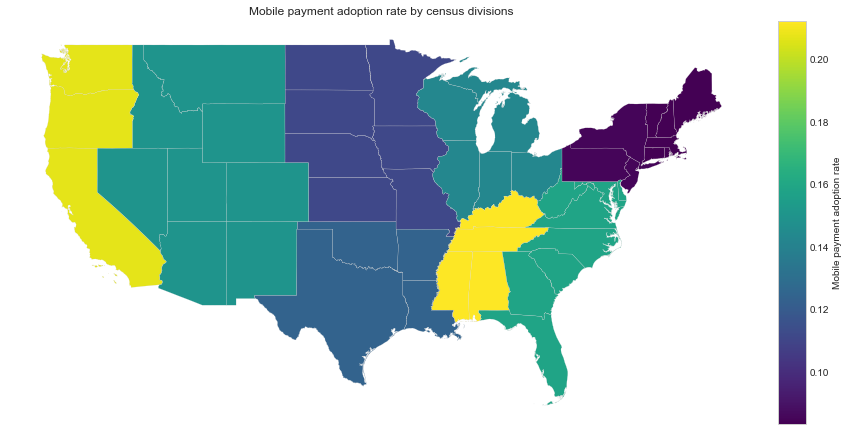

In [65]:
fig, ax = plt.subplots(figsize=(16, 10))

states.boundary.plot(ax=ax, color='lightgrey', linewidth=0.15)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=-1)

states.plot(column='adoption_rate',ax=ax, cmap='viridis', legend=True,
            legend_kwds={'label': "Mobile payment adoption rate"},
           cax=cax)
ax.axis("off")
ax.set(title='Mobile payment adoption rate by census divisions')

###  Household income

- Most household incomes falls into bins greater than 13 (above $60000)

- Weighted median is in bin 13 (50000-59999)

- There seems to be a roughly increasing trend in adoption rate as income increases ( the trend is more "bumpy" for lower buckets of household incomes, potentially because there are fewer observations/ weights in those buckets)

In [66]:
dict_labels_hhincome = {
    1: 'Less than 5,000', 
    2:  '5,000 to 7,499',
    3:  '7,500 to 9,999',
    4:  '10,000 to 12,499',
    5:  '12,500 to 14,999',
    6:  '15,000 to 19,999',
    7:  '20,000 to 24,999',
    8:  '25,000 to 29,999',
    9:  '30,000 to 34,999',
    10: '35,000 to 39,999',
    11: '40,000 to 49,999',
    12: '50,000 to 59,999',
    13: '60,000 to 74,999',
    14: '75,000 to 99,999',
    15: '100,000 to 149,999',
    16:  '150,000 or more'
}

In [67]:
weighted_describe(df.hhincome[df.hhincome.notnull()], df.r_weight[df.hhincome.notnull()], name='')

sum_w     3179.415050
mean        11.467317
std          4.038922
min          1.000000
25%          9.000000
median      13.000000
75%         15.000000
max         16.000000
dtype: float64

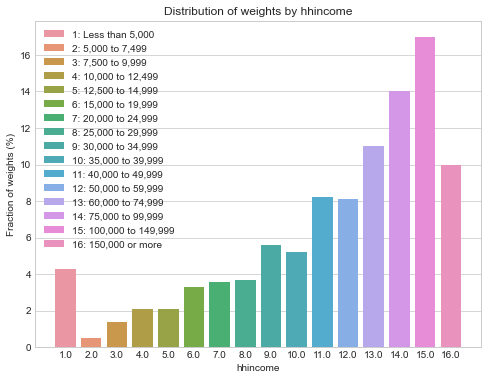

In [68]:
fig, ax = plot_hist_wts_cat_var(df[df.hhincome.notnull()], 'hhincome', 'r_weight', dict_labels_hhincome)

[Text(0.5, 1.0, 'Adoption rate by Household income'),
 Text(0, 0.5, 'average weighted adoption rate')]

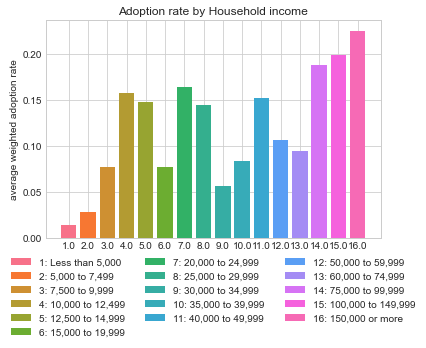

In [69]:
fig, ax = plot_weighted_outcome_by_group(df[df.hhincome.notnull()], 'mpay_tap_and_pay_1year',
                                         'hhincome', 'r_weight',
                                         dict_labels_hhincome)
ax.set(title = 'Adoption rate by Household income',
      ylabel = 'average weighted adoption rate')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=3)

### Education

- Majority of respondants (using weights) are either high school graduates/ some college/ college graduates/ master 

- Adoption rate seems to increase with level of education

In [70]:
dict_labels_education = {
    2: '1st, 2nd, 3rd, or 4th grade',
    3: '5th or 6th grade',
    4: '7th or 8th grade',
    5: '9th grade',
    6: '10th grade',
    7: '11th grade',
    8: '12th grade, no diploma',
    9: 'High school graduate - high school diploma or the equivalent (for example GED) ',
    10: 'Some college but no degree',
    11: 'Associate degree in college - Occupational/vocational program',
    12: 'Associate degree in college - Academic program',
    13: 'Bachelors degree (for example: BA, AB, BS)',
    14: 'Masters degree (for example: MA, MS, MEng, MEd, MSW, MBA)',
    15: 'Professional school degree (for example: MD, DDS, DVM, LLB, JD)',
    16: 'Doctorate degree (for example: PhD, EdD)'
}

In [71]:
weighted_describe(df.education[df.education.notnull()], df.r_weight[df.education.notnull()], name='')

sum_w     3180.982106
mean        10.792239
std          2.351438
min          2.000000
25%          9.000000
median      10.000000
75%         13.000000
max         16.000000
dtype: float64

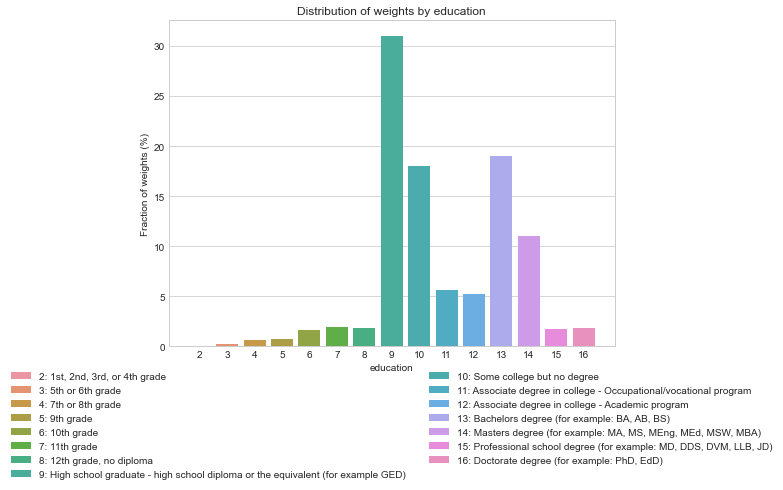

In [72]:
fig, ax = plot_hist_wts_cat_var(df[df.education.notnull()], 'education', 'r_weight', dict_labels_education)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2)

[Text(0.5, 1.0, 'Adoption rate by education'),
 Text(0, 0.5, 'average weighted adoption rate')]

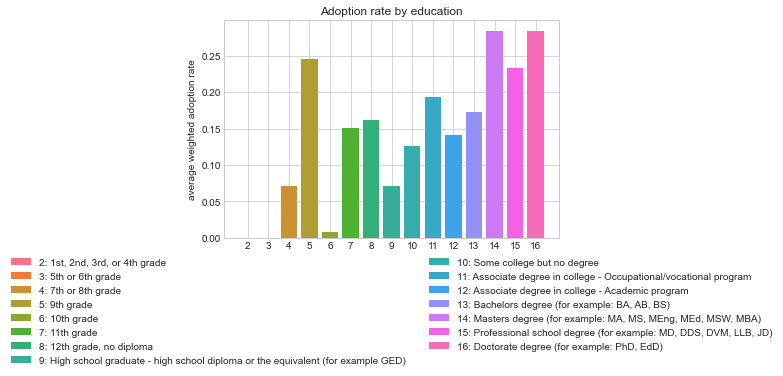

In [73]:
fig, ax = plot_weighted_outcome_by_group(df[df.education.notnull()], 'mpay_tap_and_pay_1year',
                                         'education', 'r_weight',
                                         dict_labels_education)
ax.set(title = 'Adoption rate by education',
      ylabel = 'average weighted adoption rate')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2)

### Credit score

- Median (self-reported) fico score group (weighted) is 700-749 (disregarding respondants who reported "I don't know")

- There is no clear relationship between credit score and adoption rate from the figure.

In [74]:
dict_labels_fico = {
    1: 'Below 600',
    2: '600-649',
    3: '650-699',
    4: '700-749',
    5: '750-800',
    6: 'Above 800',
    7: 'I don’t know'
}

In [75]:
weighted_describe(df.fico_score[(df.fico_score.notnull())&(df.fico_score < 7)], df.r_weight[(df.fico_score.notnull())&(df.fico_score<7)], name='')

sum_w     2808.657439
mean         3.828950
std          1.747325
min          1.000000
25%          2.000000
median       4.000000
75%          5.000000
max          6.000000
dtype: float64

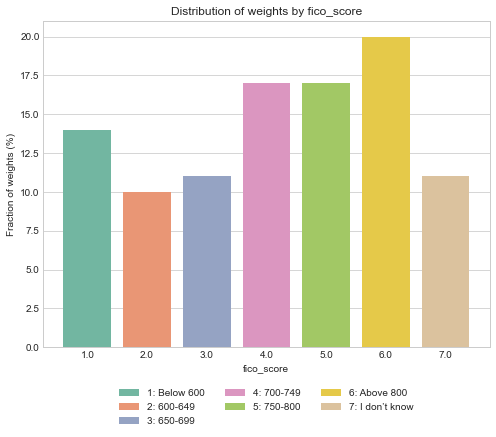

In [76]:
fig, ax = plot_hist_wts_cat_var(df[df.fico_score.notnull()], 'fico_score', 'r_weight', dict_labels_fico)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3)

[Text(0.5, 1.0, 'Adoption rate by fico score'),
 Text(0, 0.5, 'average weighted adoption rate')]

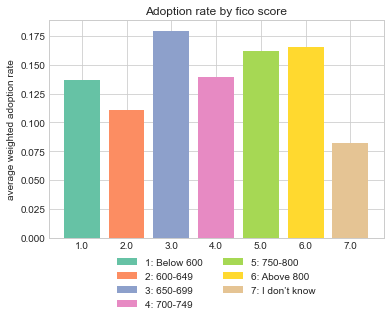

In [77]:
fig, ax = plot_weighted_outcome_by_group(df[df.fico_score.notnull()], 'mpay_tap_and_pay_1year',
                                         'fico_score', 'r_weight',
                                         dict_labels_fico)
ax.set(title = 'Adoption rate by fico score',
      ylabel = 'average weighted adoption rate')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2)

###  Assets amd Home ownership 

- Most people are homeowneres

- Surprisingly, home owners are less likely to adopt 

- Value of home and non-home assets is pretty skewed, so in model training one may want to do some transformation (e.g., log transform)

- Adoption rate is positively related to value of home and non-home assets 

In [78]:
dict_labels_ownhome = {0: 'Non home-owner', 1:'Home owner'}

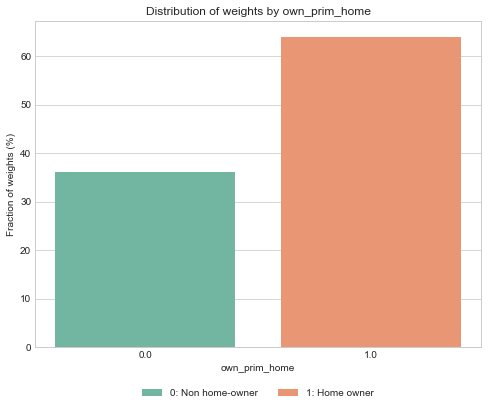

In [79]:
fig, ax = plot_hist_wts_cat_var(df[df.own_prim_home.notnull()], 'own_prim_home', 'r_weight', dict_labels_ownhome)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3)

[Text(0.5, 1.0, 'Adoption rate by home ownership status'),
 Text(0, 0.5, 'average weighted adoption rate')]

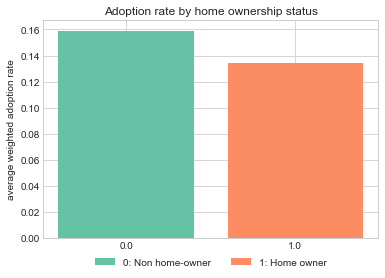

In [80]:
fig, ax = plot_weighted_outcome_by_group(df[df.own_prim_home.notnull()], 'mpay_tap_and_pay_1year',
                                         'own_prim_home', 'r_weight',
                                         dict_labels_ownhome)
ax.set(title = 'Adoption rate by home ownership status',
      ylabel = 'average weighted adoption rate')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2)

#### Value of home

- Excluding values of zero since I imputed that the home value for non-home owners to be zero

<AxesSubplot:xlabel='prim_home_mkt_value', ylabel='Density'>

[Text(0.5, 1.0, 'Distribution of home value')]

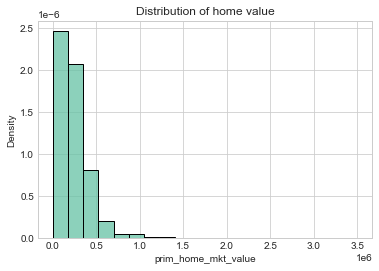

In [81]:
# Only look at people who are working/ on leave
fig, ax = plt.subplots()
sns.histplot(x = 'prim_home_mkt_value', data = df[(df.prim_home_mkt_value.notnull()) & (df.prim_home_mkt_value > 0)],
             weights = 'r_weight', kde = False,
             bins = 20, stat = 'density')
ax.set(title='Distribution of home value')

In [82]:
# Descriptive statistics for people who have home value > 0
weighted_describe(df.prim_home_mkt_value[(df.prim_home_mkt_value.notnull())&(df.prim_home_mkt_value > 0)], df.r_weight[(df.prim_home_mkt_value.notnull())&(df.prim_home_mkt_value>0)], name='')

sum_w     1.998963e+03
mean      2.478716e+05
std       2.250358e+05
min       1.000000e+00
25%       1.100000e+05
median    2.000000e+05
75%       3.250000e+05
max       3.500000e+06
dtype: float64

<AxesSubplot:xlabel='log_home_val', ylabel='Density'>

[Text(0.5, 1.0, 'Distribution of log home value')]

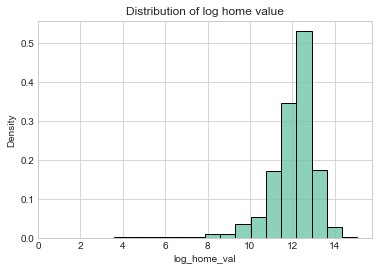

In [83]:
fig, ax = plt.subplots()
sns.histplot(x = 'log_home_val', data =  df[df.prim_home_mkt_value.notnull()&(df.prim_home_mkt_value > 0)].assign(log_home_val =lambda x: np.log(x.prim_home_mkt_value+1)),
             weights = 'r_weight', kde = False,
             bins = 20, stat = 'density')
ax.set(title='Distribution of log home value')

In [84]:
print(
    smf.wls(formula='mpay_tap_and_pay_1year~np.log(prim_home_mkt_value+1)',
            data=df[df.own_prim_home == 1],
            weights=df.r_weight[df.own_prim_home == 1],
           missing='drop')\
      .fit(cov_type='HC1').summary()
)

                              WLS Regression Results                              
Dep. Variable:     mpay_tap_and_pay_1year   R-squared:                       0.006
Model:                                WLS   Adj. R-squared:                  0.005
Method:                     Least Squares   F-statistic:                     8.426
Date:                    Sun, 26 Sep 2021   Prob (F-statistic):            0.00374
Time:                            23:55:01   Log-Likelihood:                -1196.6
No. Observations:                    2278   AIC:                             2397.
Df Residuals:                        2276   BIC:                             2409.
Df Model:                               1                                         
Covariance Type:                      HC1                                         
                                      coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------

#### Non-home assets

<AxesSubplot:xlabel='assets_non_home_mkt_value', ylabel='Density'>

[Text(0.5, 1.0, 'Distribution of non-home assets value')]

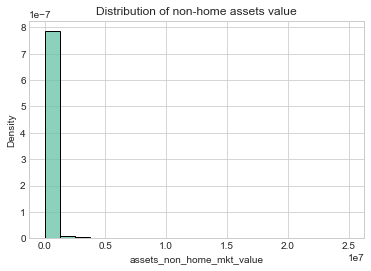

In [85]:
# Only look at people who are working/ on leave
fig, ax = plt.subplots()
sns.histplot(x = 'assets_non_home_mkt_value', data = df[df.assets_non_home_mkt_value.notnull()],
             weights = 'r_weight', kde = False,
             bins = 20, stat = 'density')
ax.set(title='Distribution of non-home assets value')

<AxesSubplot:xlabel='log_nonhome_assets_val', ylabel='Density'>

[Text(0.5, 1.0, 'Distribution of log non-home assets value')]

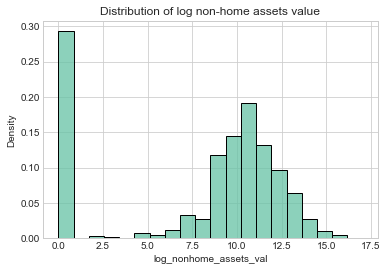

In [86]:
# Only look at people who are working/ on leave
fig, ax = plt.subplots()
sns.histplot(x = 'log_nonhome_assets_val', data = df[df.assets_non_home_mkt_value.notnull()].assign(log_nonhome_assets_val = lambda x: np.log(x.assets_non_home_mkt_value+1)),
             weights = 'r_weight', kde = False,
             bins = 20, stat = 'density')
ax.set(title='Distribution of log non-home assets value')

In [87]:
print(
    smf.wls(
        formula='mpay_tap_and_pay_1year~np.log(assets_non_home_mkt_value+1)',
        data=df,
        weights=df.r_weight,
        missing='drop'
    )\
    .fit(cov_type='HC1')\
    .summary()
)

                              WLS Regression Results                              
Dep. Variable:     mpay_tap_and_pay_1year   R-squared:                       0.005
Model:                                WLS   Adj. R-squared:                  0.004
Method:                     Least Squares   F-statistic:                     7.187
Date:                    Sun, 26 Sep 2021   Prob (F-statistic):            0.00738
Time:                            23:55:01   Log-Likelihood:                -1783.3
No. Observations:                    3118   AIC:                             3571.
Df Residuals:                        3116   BIC:                             3583.
Df Model:                               1                                         
Covariance Type:                      HC1                                         
                                            coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------

### Current living situation


In [88]:
dict_labels_currentlivingsituation = {
    1: 'Married or lives with partner',
    2: 'Separated',
    3: 'Divorced',
    4: 'Widowed',
    5: 'Never married'
}

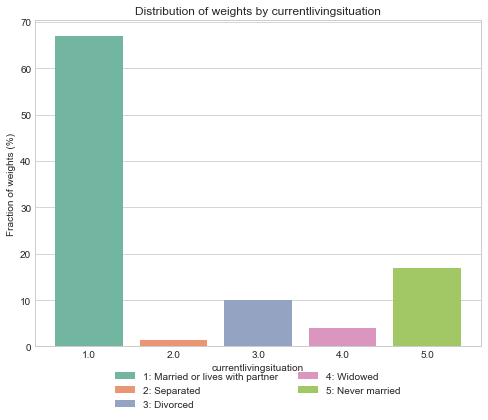

In [89]:
fig, ax = plot_hist_wts_cat_var(df[df.currentlivingsituation.notnull()], 'currentlivingsituation', 'r_weight', dict_labels_currentlivingsituation)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2)

[Text(0.5, 1.0, 'Adoption rate by current living situation'),
 Text(0, 0.5, 'average weighted adoption rate')]

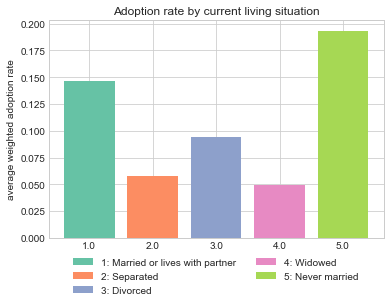

In [90]:
fig, ax = plot_weighted_outcome_by_group(df[df.currentlivingsituation.notnull()], 'mpay_tap_and_pay_1year',
                                         'currentlivingsituation', 'r_weight',
                                         dict_labels_currentlivingsituation)
ax.set(title = 'Adoption rate by current living situation',
      ylabel = 'average weighted adoption rate')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2)

### Debit and credit card usage

- Majority of the respondants have adopted credit cards and debit cards.

- Credit and debit card holders have higher mobile payment adoption rate.

No handles with labels found to put in legend.


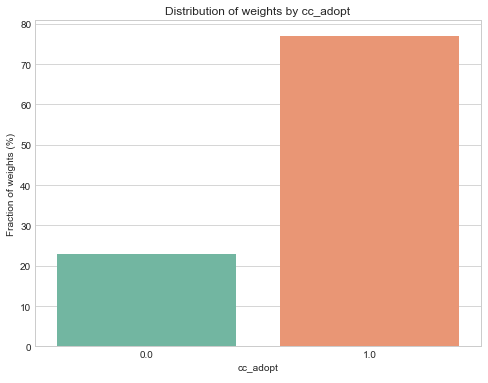

In [91]:
fig, ax = plot_hist_wts_cat_var(df[df.cc_adopt.notnull()], 'cc_adopt', 'r_weight', {})
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2)

[Text(0.5, 1.0, 'Adoption rate by credit card holder status'),
 Text(0, 0.5, 'average weighted adoption rate')]

No handles with labels found to put in legend.


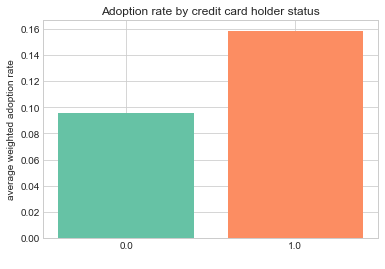

In [92]:
fig, ax = plot_weighted_outcome_by_group(df[df.cc_adopt.notnull()], 'mpay_tap_and_pay_1year',
                                         'cc_adopt', 'r_weight',
                                         {})
ax.set(title = 'Adoption rate by credit card holder status',
      ylabel = 'average weighted adoption rate')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2)

No handles with labels found to put in legend.


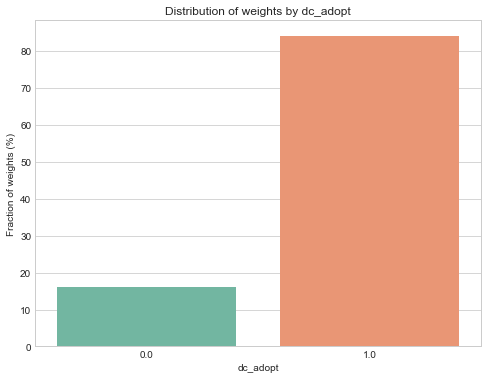

In [93]:
fig, ax = plot_hist_wts_cat_var(df[df.cc_adopt.notnull()], 'dc_adopt', 'r_weight', {})
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2)

[Text(0.5, 1.0, 'Adoption rate by debit card holder status'),
 Text(0, 0.5, 'average weighted adoption rate')]

No handles with labels found to put in legend.


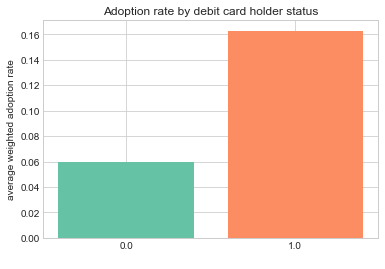

In [94]:
fig, ax = plot_weighted_outcome_by_group(df[df.dc_adopt.notnull()], 'mpay_tap_and_pay_1year',
                                         'dc_adopt', 'r_weight',
                                         {})
ax.set(title = 'Adoption rate by debit card holder status',
      ylabel = 'average weighted adoption rate')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2)

#### Number of transactions

- Since the distribution is skewed, it's better to log transform the variable for model training

<AxesSubplot:xlabel='cc_typ', ylabel='Density'>

[Text(0.5, 1.0, 'Distribution of number of credit card payments')]

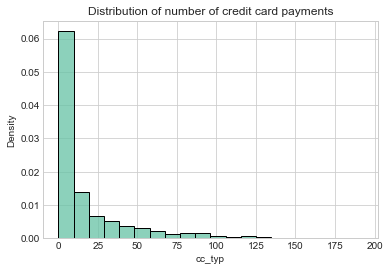

In [95]:
fig, ax = plt.subplots()
sns.histplot(x = 'cc_typ', data = df[(df.cc_typ.notnull())],
             weights = 'r_weight', kde = False,
             bins = 20, stat = 'density')
ax.set(title='Distribution of number of credit card payments')

<AxesSubplot:xlabel='log_cc_typ', ylabel='Density'>

[Text(0.5, 1.0, 'Distribution of log number of credit card payments')]

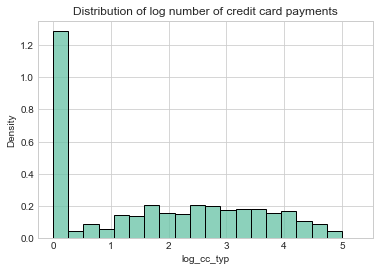

In [96]:
fig, ax = plt.subplots()
sns.histplot(x = 'log_cc_typ', data = df[(df.cc_typ.notnull())].assign(log_cc_typ=lambda x:np.log(x.cc_typ+1)),
             weights = 'r_weight', kde = False,
             bins = 20, stat = 'density')
ax.set(title='Distribution of log number of credit card payments')

In [97]:
print(
    smf.wls(
        formula='mpay_tap_and_pay_1year~np.log(cc_typ+1)',
        data=df[df.cc_typ.notnull()],
        weights=df.r_weight[df.cc_typ.notnull()],
        missing='drop'
    )\
    .fit(cov_type='HC1')\
    .summary()
)

                              WLS Regression Results                              
Dep. Variable:     mpay_tap_and_pay_1year   R-squared:                       0.031
Model:                                WLS   Adj. R-squared:                  0.030
Method:                     Least Squares   F-statistic:                     24.60
Date:                    Sun, 26 Sep 2021   Prob (F-statistic):           7.63e-07
Time:                            23:55:04   Log-Likelihood:                -1154.2
No. Observations:                    2117   AIC:                             2312.
Df Residuals:                        2115   BIC:                             2324.
Df Model:                               1                                         
Covariance Type:                      HC1                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------

<AxesSubplot:xlabel='dc_typ', ylabel='Density'>

[Text(0.5, 1.0, 'Distribution of number of debit card payments')]

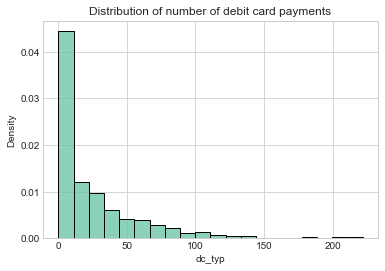

In [98]:
fig, ax = plt.subplots()
sns.histplot(x = 'dc_typ', data = df[(df.dc_typ.notnull())],
             weights = 'r_weight', kde = False,
             bins = 20, stat = 'density')
ax.set(title='Distribution of number of debit card payments')

<AxesSubplot:xlabel='log_dc_typ', ylabel='Density'>

[Text(0.5, 1.0, 'Distribution of log number of debit card payments')]

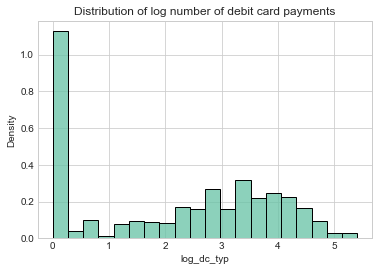

In [99]:
fig, ax = plt.subplots()
sns.histplot(x = 'log_dc_typ', data = df[(df.dc_typ.notnull())].assign(log_dc_typ=lambda x:np.log(x.dc_typ+1)),
             weights = 'r_weight', kde = False,
             bins = 20, stat = 'density')
ax.set(title='Distribution of log number of debit card payments')

In [100]:
print(
    smf.wls(
        formula='mpay_tap_and_pay_1year~np.log(dc_typ+1)',
        data=df[df.dc_typ.notnull()],
        weights=df.r_weight[df.dc_typ.notnull()],
        missing='drop'
    )\
    .fit(cov_type='HC1')\
    .summary()
)

                              WLS Regression Results                              
Dep. Variable:     mpay_tap_and_pay_1year   R-squared:                       0.003
Model:                                WLS   Adj. R-squared:                  0.002
Method:                     Least Squares   F-statistic:                     2.652
Date:                    Sun, 26 Sep 2021   Prob (F-statistic):              0.104
Time:                            23:55:04   Log-Likelihood:                -1184.3
No. Observations:                    2117   AIC:                             2373.
Df Residuals:                        2115   BIC:                             2384.
Df Model:                               1                                         
Covariance Type:                      HC1                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------

# Correlation between variables

- Certain variables are correlated with each others: dc_adopt and dc_typ, cc_adopy and cc_typ

- Intuitively, household income is positively related to education, number of credit card paymemt. amd value of home.

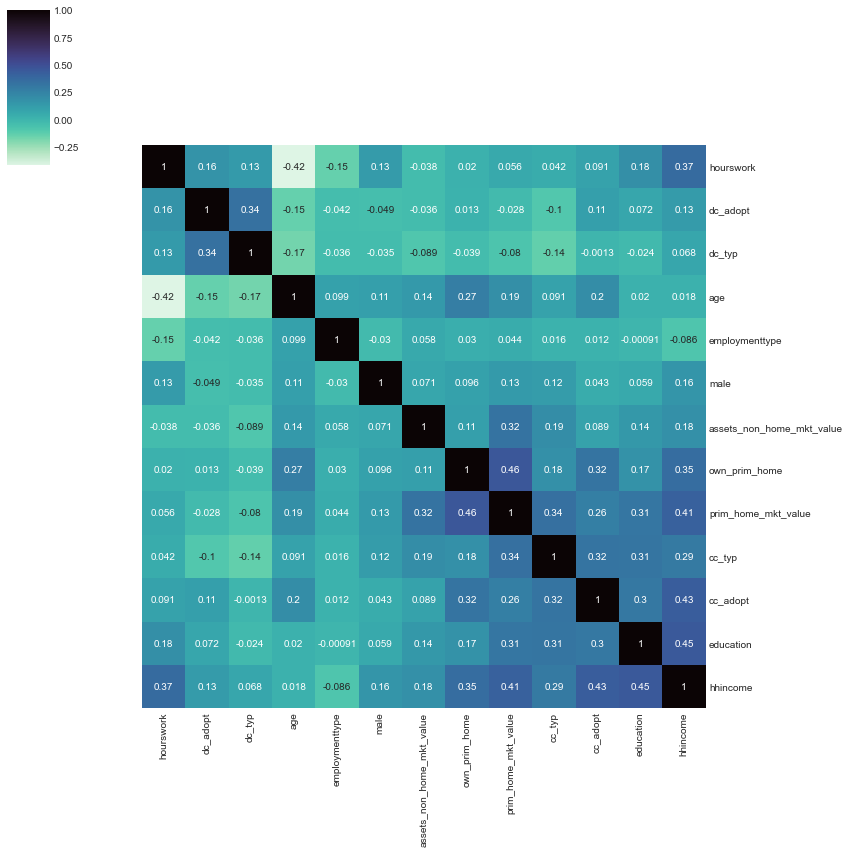

In [101]:
# Show correlation between variables, using hierarchical clustering to order variables for visualization
cg = sns.clustermap(df.drop(columns=['id', 'r_weight', 'cellphone',
                                     'laborstatus', 'currentlivingsituation', 'census_division',
                                    'race', 'mpay_tap_and_pay_1year', 'fico_score']).corr(),
                    annot=True,
                   fmt='.2g',
                   figsize=(12,12),
                   cmap='mako_r')
cg.ax_row_dendrogram.set_visible(False)
cg.ax_col_dendrogram.set_visible(False)

# Preprocessing and Feature Engineering for model training

In [102]:
# Check missing values
show_percent_missing(df)

,missing,percent
employmenttype,1280,40.10
dc_typ,1075,33.68
cc_typ,1075,33.68
assets_non_home_mkt_value,74,2.32
dc_adopt,51,1.60
prim_home_mkt_value,30,0.94
own_prim_home,13,0.41
fico_score,12,0.38
race,6,0.19
cc_adopt,4,0.13


In [103]:
# Remove rows with certain missing values
cols_dropna = [
    'cc_adopt', 'census_division',
    'hhincome', 'laborstatus', 'dc_adopt', 'own_prim_home',
    'assets_non_home_mkt_value', 'race'
]

df_clean = df.dropna(subset=cols_dropna)
df_clean.shape

(3064, 22)

## Drop columns with too many missing values

In [104]:
# Since cc_typ and dc_typ have too many missing values (even for credit and debit card holders), I decide to drop them
df_clean = df_clean.drop(columns=['dc_typ', 'cc_typ'])

## Filling in missing values

In [105]:
df_clean = df_clean.fillna({'employmenttype': 5})

In [106]:
# Check that there are no more missing values
show_percent_missing(df_clean)

,missing,percent
age,0,0.0
cellphone,0,0.0
dc_adopt,0,0.0
cc_adopt,0,0.0
r_weight,0,0.0
fico_score,0,0.0
id,0,0.0
race,0,0.0
laborstatus,0,0.0
hourswork,0,0.0


## Values recoding & transformation

In [107]:
# Record household income and fico scores to actual values
# hhincome and fico (ph006)
dict_hhincome_recode =  {1: 2500,
                        2: 6250,
                        3: 8750,
                        4: 11250,
                        5: 13750,
                        6: 17500,
                        7: 22500,
                        8: 27500,
                        9: 32500,
                        10: 37500,
                        11: 46000,
                        12: 55000,
                        13: 67500,
                        14: 87500,
                        15: 125000,
                        16: 150000}


dict_fico_recode = {1: 600,
                    2: 625,
                    3: 675,
                    4: 725,
                    5: 775,
                    6: 900,
                    7: np.nan}

In [108]:
df_clean['log_hhincome'] = np.log(df_clean['hhincome'].replace(to_replace=dict_hhincome_recode))

In [109]:
df_clean.loc[df_clean.fico_score == 7,'fico_score'] = np.nan
df_clean['fico_score'] = df_clean['fico_score'].fillna(df_clean['fico_score'].median())
df_clean['log_fico_score'] = np.log(df_clean['fico_score'].replace(dict_fico_recode))

In [110]:
# Log transform
df_clean['log_prim_home_mkt_value'] = np.log(df_clean['prim_home_mkt_value'] + 1)
df_clean['log_assets_non_home_mkt_value'] = np.log(df_clean['assets_non_home_mkt_value'] + 1)

In [111]:
# Drop the original columns
df_clean = df_clean.drop(columns=['hhincome', 'fico_score',
                                  'prim_home_mkt_value', 'assets_non_home_mkt_value'])

## Change categorical variables to string

In [112]:
# First change the categorical variables into string
vars_cat = ['census_division', 'currentlivingsituation',
            'employmenttype','laborstatus']

df_clean = df_clean.astype({x:'str' for x in vars_cat})

## Drop unnecessary columns for model training

In [113]:
vars_drop = ['cellphone', 'id']
df_clean = df_clean.drop(columns=vars_drop)

### Save for model training

In [114]:
# save df_clean for tmp purpose
df_clean.to_csv('/Users/sharonshiao/Dropbox/Data Science/projects/payment/data/processed/data_preprocessed_final.csv', index = False)